In [1]:
import pandas as pd
import numpy as np
import forestplot as fp
import os
from scipy.stats import ttest_rel


In [2]:
def load_csvs(directory):
    # Create an empty dictionary to store the dataframes
    dataframes = {}

    # Loop through each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):  # Check if the file is a CSV
            file_path = os.path.join(directory, filename)
            df_name = filename[:-4]  # Remove the '.csv' from the filename to use as the DataFrame name
            dataframes[df_name] = pd.read_csv(file_path)  # Read the CSV file and store it in the dictionary

    return dataframes

# Specify the directory containing your CSV files
directory = '../data/metrics/'

# Load all CSV files into a dictionary
metrics = load_csvs(directory)


In [3]:
original_metrics = metrics['glc']
cut_metrics = metrics['cut_glc']

In [4]:
dfs = [original_metrics, cut_metrics]

In [6]:
for i in dfs:
    i['tir_hypo'] = i['tir_lv1_hypo'] + i['tir_lv2_hypo']
    i['tir_hyper'] = i['tir_lv1_hyper'] + i['tir_lv2_hyper']

In [7]:
metrics = ['avg_glc', 'ea1c', 'sd', 'cv', 'auc', 'lbgi', 'hbgi', 
           'tir_normal', 'tir_hypo', 'tir_hyper',
            'number_hypos','number_lv2_hypos', 'number_hypers', 
            'number_lv2_hypers']

### All metrics

In [45]:
import matplotlib.pyplot as plt
import pyCompare

# Assuming dm_results and ig_results are your DataFrames and have the same columns
col_names = metrics # or a list of metric names you want to plot

# Number of rows and columns for subplots
n_rows = 5
n_cols = 3

# Create matplotlib figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 20))

# Loop through the metrics and create Bland-Altman plots
for i, col_name in enumerate(col_names):
    ax = axes[i // n_cols, i % n_cols]
    pyCompare.blandAltman(original_metrics[col_name], cut_metrics[col_name], ax=ax)
    ax.set_title(f'({chr(97 + i)}) {col_name}')  # Creating a subplot title like (a) Metric 1
    ax.set_xlabel('Mean of methods')
    ax.set_ylabel('Difference between methods')

# If there's an odd number of metrics, remove the last subplot (if it's empty)
if len(col_names) % 2:
    fig.delaxes(axes[-1, -1])

# Adjust layout and save figure
fig.tight_layout()
plt.show()


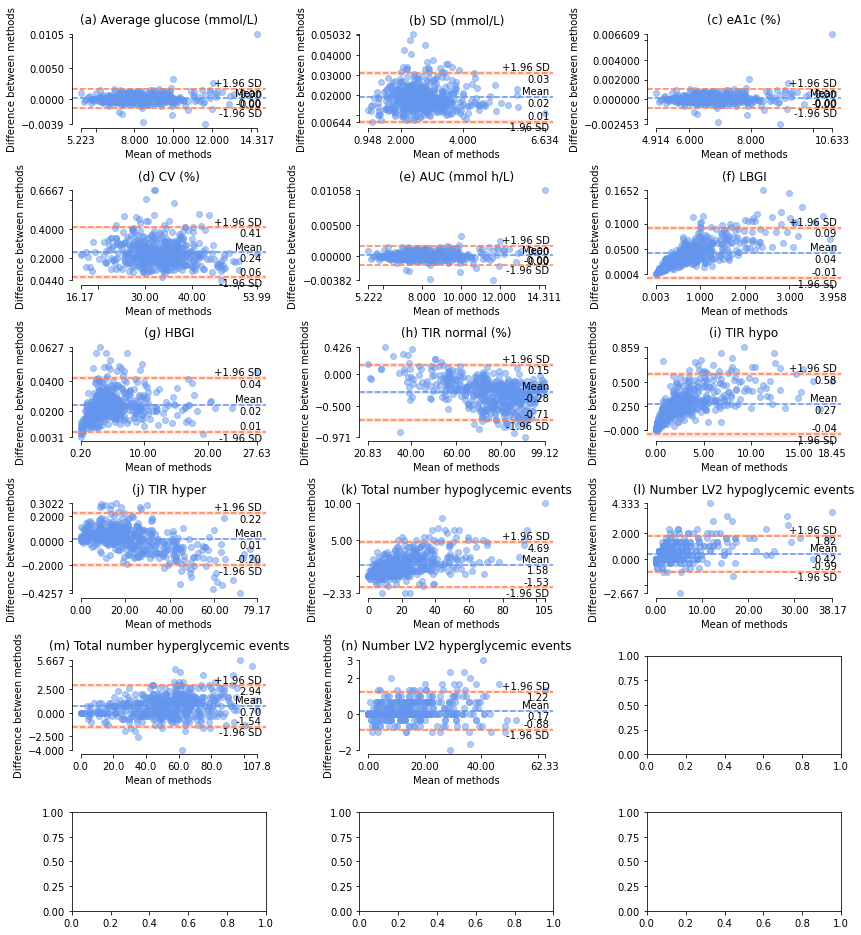

In [ ]:
import matplotlib.pyplot as plt
import pyCompare

# Assuming dm_results and ig_results are your DataFrames and have the same columns
col_names = metrics # or a list of metric names you want to plot

# Number of rows and columns for subplots
n_rows = len(col_names) // 3 + len(col_names) % 3
n_cols = 3

# Create matplotlib figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 13))

# Loop through the metrics and create Bland-Altman plots
for i, col_name in enumerate(col_names):
    ax = axes[i // n_cols, i % n_cols]
    pyCompare.blandAltman(all_cgm[col_name], mean_linear_df[col_name], ax=ax)
    ax.set_title(f'({chr(97 + i)}) {col_name}')  # Creating a subplot title like (a) Metric 1
    ax.set_xlabel('Mean of methods')
    ax.set_ylabel('Difference between methods')

# If there's an odd number of metrics, remove the last subplot (if it's empty)
if len(col_names) % 2:
    fig.delaxes(axes[-1, -1])

# Adjust layout and save figure
fig.tight_layout()
plt.show()


## Tabular agreement

In [8]:
# Mapping of metrics to their decimal places
decimal_places = {
    'avg_glc': 1,  # Assuming 'avg_glc' represents 'Average glucose (mmol/L)'
    'sd': 1,       # Standard deviation in mmol/L
    'ea1c': 2,     # Estimated Average glucose as a percentage
    'cv': 1,       # Coefficient of variation in percentage
    'auc': 1,      # Area under curve in mmol h/L
    'lbgi': 2,     # Low Blood Glucose Index
    'hbgi': 2,     # High Blood Glucose Index
    'tir_normal': 1,  # Time in Range normal in percentage
    'tir_hypo': 2,    # Time in Range hypoglycemia
    'tir_hyper': 1,   # Time in Range hyperglycemia
    'number_hypos': 1,        # Total number of hypoglycemic events
    'number_lv2_hypos': 1,    # Number of Level 2 hypoglycemic events
    'number_hypers': 1,       # Total number of hyperglycemic events
    'number_lv2_hypers': 1    # Number of Level 2 hyperglycemic events
}


In [9]:

def format_value(value, key):
    """Format the value according to the specified number of decimal places."""
    if key in decimal_places:
        return f"{value:.{decimal_places[key]}f}"
    return str(value)

def agreement_analysis(compare, original, metrics):
    results = {
        'Metric': [],
        'Original Average': [],
        'Cut Average': [],
        'Mean Difference': [],
        'Lower Limit': [],
        'Upper Limit': [],
        'P-value': []
    }

    for metric in metrics:
        differences = compare[metric] - original[metric]
        sqrt_len = np.sqrt(len(differences))

        mean_diff = differences.mean()
        std_diff = differences.std(ddof=1)
        lower_limit = mean_diff - 1.96 * (std_diff / sqrt_len)
        upper_limit = mean_diff + 1.96 * (std_diff / sqrt_len)
        stat, p_value = ttest_rel(original[metric], compare[metric])

        # Calculate and format averages and CI for each dataset
        original_avg = original[metric].mean()
        original_std = original[metric].std(ddof=1)
        original_lower = original_avg - 1.96 * (original_std / sqrt_len)
        original_upper = original_avg + 1.96 * (original_std / sqrt_len)

        cut_avg = compare[metric].mean()
        cut_std = compare[metric].std(ddof=1)
        cut_lower = cut_avg - 1.96 * (cut_std / sqrt_len)
        cut_upper = cut_avg + 1.96 * (cut_std / sqrt_len)

        # Append formatted results
        results['Metric'].append(metric)
        results['Original Average'].append(f"{format_value(original_avg, metric)} ({format_value(original_lower, metric)} to {format_value(original_upper, metric)})")
        results['Cut Average'].append(f"{format_value(cut_avg, metric)} ({format_value(cut_lower, metric)} to {format_value(cut_upper, metric)})")
        results['Mean Difference'].append(format_value(mean_diff, metric))
        results['Lower Limit'].append(format_value(lower_limit, metric))
        results['Upper Limit'].append(format_value(upper_limit, metric))
        results['P-value'].append(p_value)

    return pd.DataFrame(results)

# Example usage with dummy data
# Assuming `original` and `compare` are your DataFrame variables and `metrics` is a list of metric names
# results_df = agreement_analysis(compare, original, metrics)
# print(results_df)


In [10]:
# List of metrics to scale by a factor of 18
metrics_to_scale = ['avg_glc', 'sd', 'auc']

# Scale specified metrics in each DataFrame
for df in dfs:
    for metric in metrics_to_scale:
        if metric in df.columns:
            df[metric] = df[metric] * 18


In [18]:
agreement_df = agreement_analysis(cut_metrics, original_metrics, metrics)


In [30]:
# Replace all -0 values with 0 in the entire DataFrame
agreement_df = agreement_df.replace({'-0.0':'0', '-0':'0', '-0.00':'0.00'})


In [38]:
# Dictionary mapping old abbreviated metric names to new descriptive names
rename_dict = {
    'tir_normal': 'Time in normal range (%)',
    'tir_hypo': 'Time in hypoglycemia (%)',
    'tir_hyper': 'Time in hyperglycemia (%)',
    'number_hypos': 'Total hypoglycemic episodes',
    'number_lv2_hypos': 'LV2 hypoglycemic episodes',
    'number_hypers': 'Total hyperglycemic episodes',
    'number_lv2_hypers': 'LV2 hyperglycemic episodes',
    'avg_glc': 'Average glucose (mg/dL)', 
    'sd': 'SD (mg/dL)',
    'cv': 'CV (%)',
    'lbgi': 'LBGI',
    'hbgi': 'HBGI',
    'auc': 'AUC (mg h/dL)',
    'ea1c': 'eA1c (mmol/mol)'
}


In [39]:
agreement_df['Metric'] = agreement_df['Metric'].replace(rename_dict)

<Axes: xlabel='Mean Difference (95% CI)'>

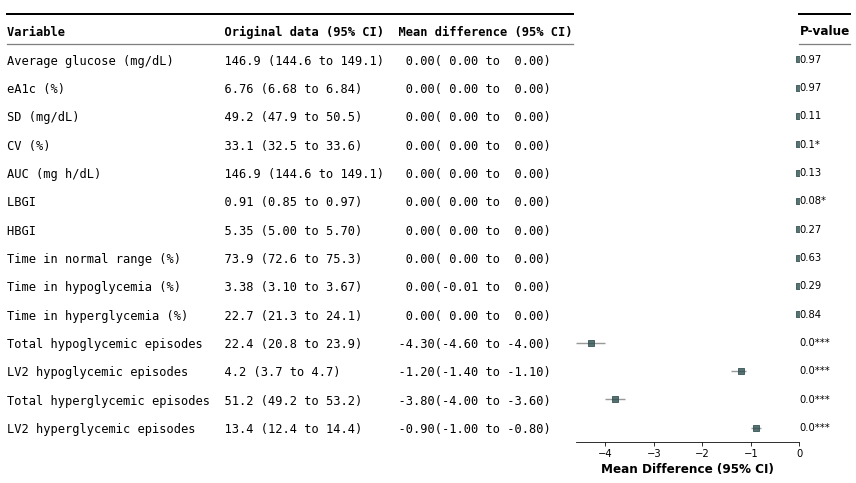

In [40]:
import matplotlib.pyplot as plt
fp.forestplot(agreement_df,  # the dataframe with results data
              estimate="Mean Difference",  # col containing estimated effect size 
              ll="Lower Limit", hl="Upper Limit",  # columns containing conf. int. lower and higher limits
              varlabel="Metric",  # column containing variable label
              #ylabel="Confidence interval",  # y-label title
              xlabel="Mean Difference (95% CI)",  # x-label title
              pval = "P-value",
              annote=['Original Average',  "est_ci"], # 'Cut Average',
              annoteheaders=['Original data (95% CI)',  'Mean difference (95% CI)'], # '15-min intervals (95% CI)',
              table=True
              )
#plt.savefig('figures/forestplot.eps', bbox_inches='tight')

#